In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
import os 
import sys
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import functions as fn

/home/phaxssi/miniconda3/envs/nlp-tasks/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/phaxssi/miniconda3/envs/nlp-tasks/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# 1. Threshold Plots

### 1.1. EM (Jaccard)

In [44]:
thresholds = np.arange(0.1, 1, 0.1)

# Función para calcular el accuracy basado en el threshold
def calculate_accuracy(jaccard_values, threshold):
    return np.mean(jaccard_values >= threshold)

# Calcular el accuracy para cada tipo de Jaccard y cada threshold
def calculate_accuracies_jaccard(df, context):
    return [calculate_accuracy(df[f'Jaccard {context}'], t) for t in thresholds]

def calculate_accuracies_cosine(df, context):
    return [calculate_accuracy(df[f'Cosine {context}'], t) for t in thresholds]

def extract_metrics_from_excel(file_path, metric_name):
    # Load the Excel file
    excel_data = pd.ExcelFile(file_path)

    # Function to extract metrics
    def extract_metric(model_data, metric_name):
        metric_row = model_data[model_data['Metric'] == metric_name]
        return [metric_row['Positive'].values[0], metric_row['Posnegative'].values[0], metric_row['Negative'].values[0]]

    # Extract data from each sheet and get the metrics
    metrics = {
        'RoBERTa': extract_metric(pd.read_excel(excel_data, sheet_name='Model 1'), metric_name),
        'Bert Multicased': extract_metric(pd.read_excel(excel_data, sheet_name='Model 2'), metric_name),
        'DistilBERT': extract_metric(pd.read_excel(excel_data, sheet_name='Model 3'), metric_name),
        'Bert Uncased': extract_metric(pd.read_excel(excel_data, sheet_name='Model 4'), metric_name)
    }

    return metrics

directory = 'results/'
files = [f for f in os.listdir(directory) if f.endswith('.json')]
dataframes =  {os.path.splitext(f)[0]: pd.read_json(os.path.join(directory, f), orient='records', lines=True) for f in files}


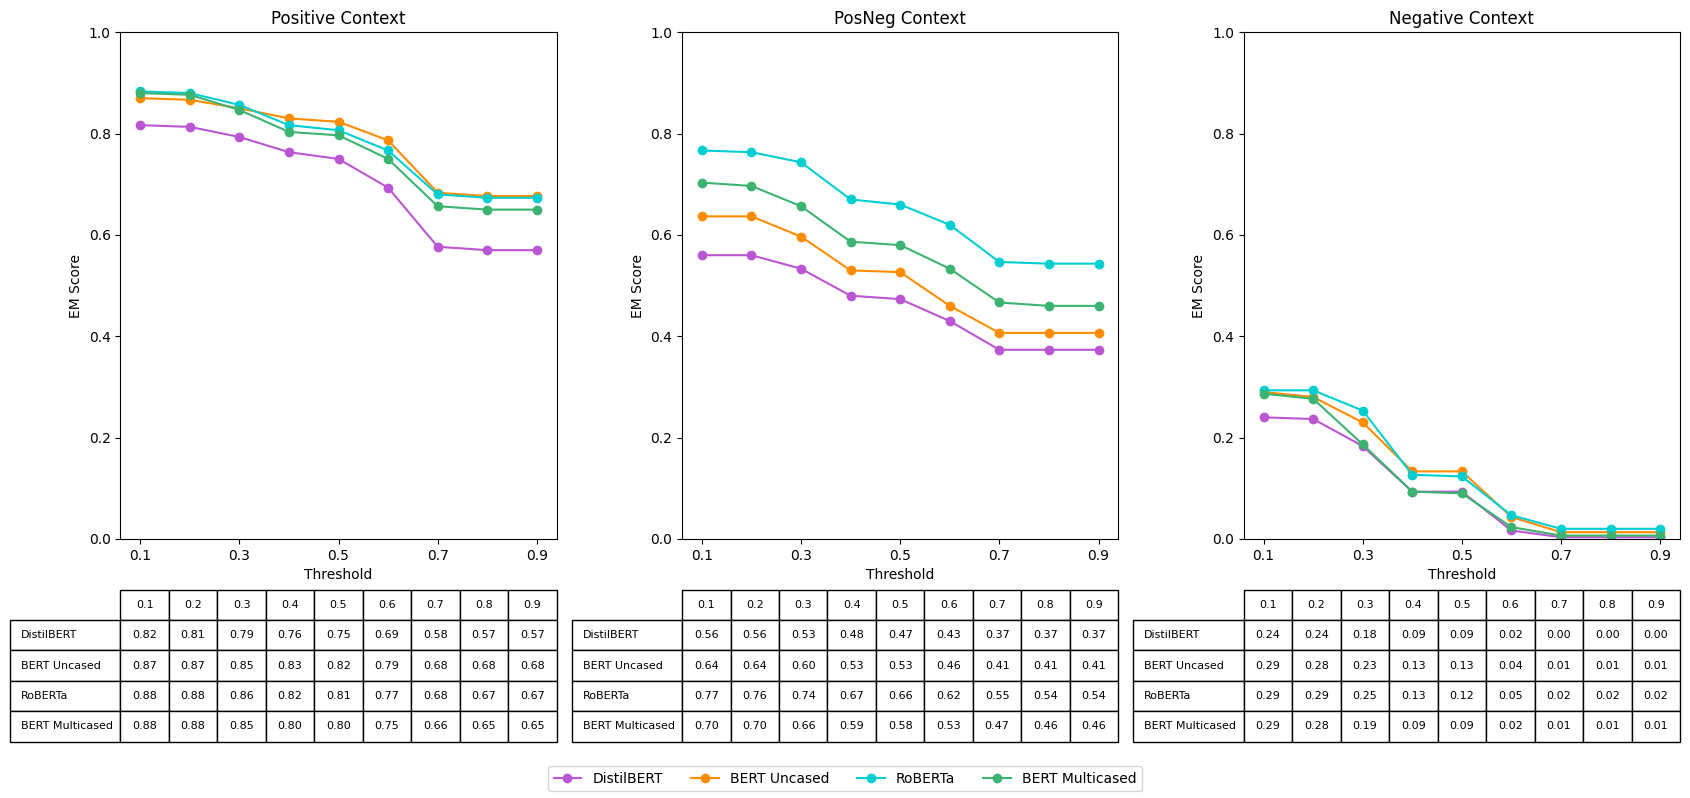

In [32]:
# Inicializar diccionarios para almacenar los resultados
accuracy_positive = {}
accuracy_posneg = {}
accuracy_negative = {}

# Calcular las accuracies para cada archivo
for name, df in dataframes.items():
    accuracy_positive[name] = calculate_accuracies_jaccard(df, 'Positive')
    accuracy_posneg[name] = calculate_accuracies_jaccard(df, 'PosNeg')
    accuracy_negative[name] = calculate_accuracies_jaccard(df, 'Negative')

# Crear los subplots
fig, axes = plt.subplots(1, 3, figsize=(17, 8), sharex=True)

# Definir los colores para cada modelo
colors = ['mediumorchid', 'darkorange', 'darkturquoise', 'mediumseagreen']

# Definir los límites del eje y para que sean iguales en todos los subplots
y_min = 0
y_max = 1

# Subplot para contexto positivo
for name, color in zip(accuracy_positive.keys(), colors):
    axes[0].plot(thresholds, accuracy_positive[name], marker='o', label=name, color=color)
axes[0].set_title('Positive Context')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('EM Score')
axes[0].set_ylim(y_min, y_max)

# Añadir la tabla para el contexto positivo
table_data = [[f"{value:.2f}" for value in accuracy_positive[name]] for name in accuracy_positive.keys()]
table = axes[0].table(cellText=table_data, rowLabels=list(accuracy_positive.keys()), colLabels=[f"{t:.1f}" for t in thresholds], loc='bottom', cellLoc='center', bbox=[0.0, -0.4, 1.0, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(8)

# Subplot para contexto PosNeg
for name, color in zip(accuracy_posneg.keys(), colors):
    axes[1].plot(thresholds, accuracy_posneg[name], marker='o', label=name, color=color)
axes[1].set_title('PosNeg Context')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('EM Score')
axes[1].set_ylim(y_min, y_max)

# Añadir la tabla para el contexto PosNeg
table_data = [[f"{value:.2f}" for value in accuracy_posneg[name]] for name in accuracy_posneg.keys()]
table = axes[1].table(cellText=table_data, rowLabels=list(accuracy_posneg.keys()), colLabels=[f"{t:.1f}" for t in thresholds], loc='bottom', cellLoc='center', bbox=[0.0, -0.4, 1.0, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(8)

# Subplot para contexto negativo
for name, color in zip(accuracy_negative.keys(), colors):
    axes[2].plot(thresholds, accuracy_negative[name], marker='o', label=name, color=color)
axes[2].set_title('Negative Context')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('EM Score')
axes[2].set_ylim(y_min, y_max)

# Añadir la tabla para el contexto negativo
table_data = [[f"{value:.2f}" for value in accuracy_negative[name]] for name in accuracy_negative.keys()]
table = axes[2].table(cellText=table_data, rowLabels=list(accuracy_negative.keys()), colLabels=[f"{t:.1f}" for t in thresholds], loc='bottom', cellLoc='center', bbox=[0.0, -0.4, 1.0, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(8)

plt.xticks(ticks=np.arange(0.1, 1.0, 0.2))
plt.tight_layout()

# Crear una sola leyenda para todos los subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(handles))

# Ajustar los márgenes para dar espacio a las tablas y la leyenda
plt.subplots_adjust(bottom=0.32)

# Guardar y mostrar el gráfico
plt.savefig('plots/em_threshold_jaccard.png', bbox_inches='tight')
plt.show()

### 1.2. EM (Jaccard)

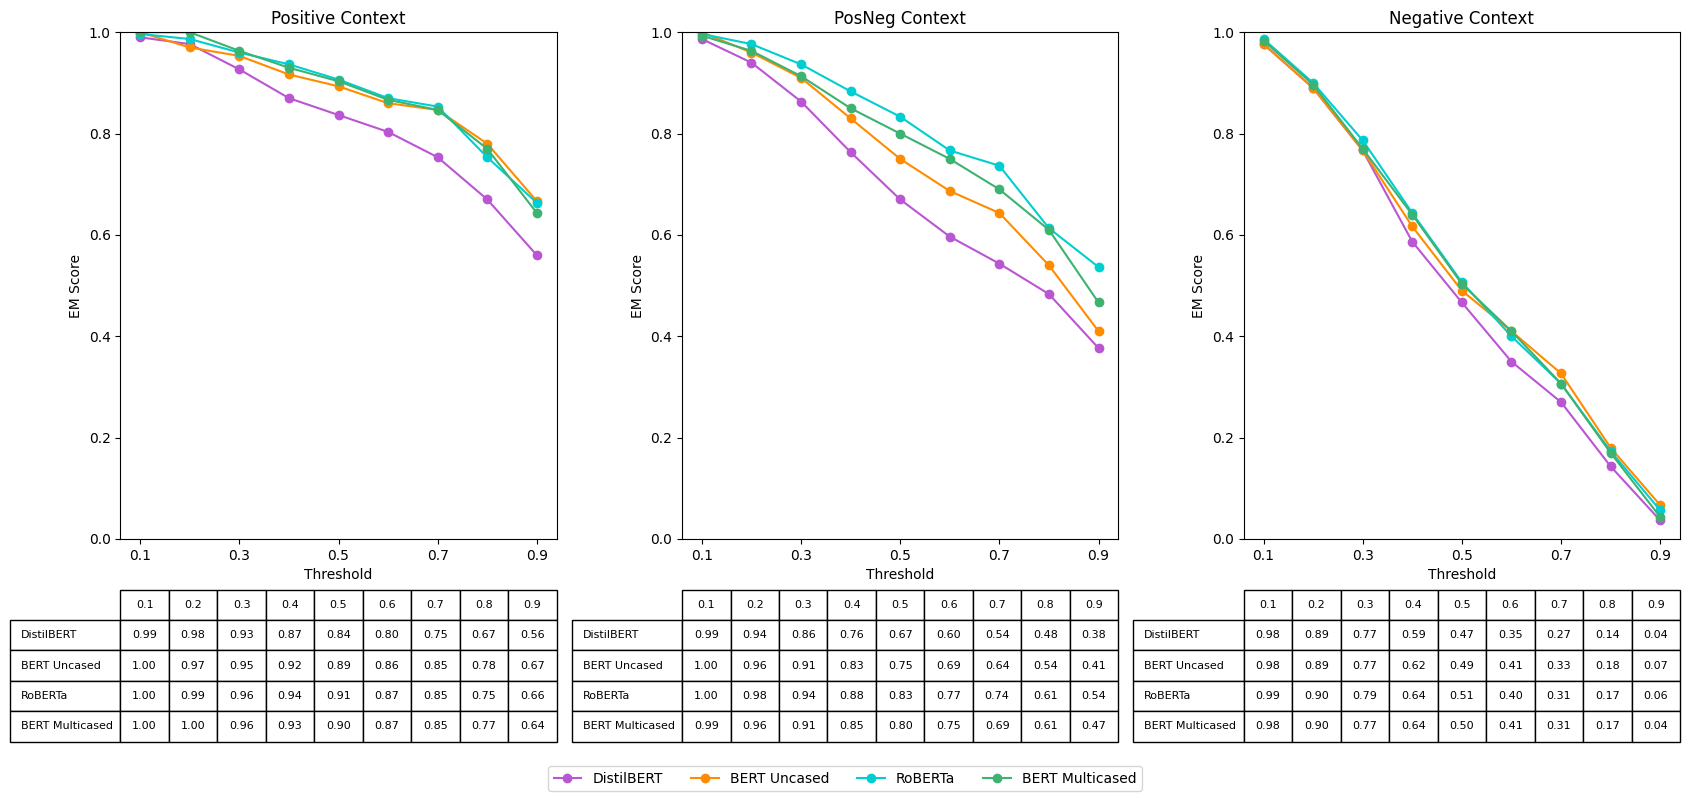

In [33]:
# Inicializar diccionarios para almacenar los resultados
accuracy_positive = {}
accuracy_posneg = {}
accuracy_negative = {}

# Calcular las accuracies para cada archivo
for name, df in dataframes.items():
    accuracy_positive[name] = calculate_accuracies_cosine(df, 'Positive')
    accuracy_posneg[name] = calculate_accuracies_cosine(df, 'PosNeg')
    accuracy_negative[name] = calculate_accuracies_cosine(df, 'Negative')

# Crear los subplots
fig, axes = plt.subplots(1, 3, figsize=(17, 8), sharex=True)

# Definir los colores para cada modelo
colors = ['mediumorchid', 'darkorange', 'darkturquoise', 'mediumseagreen']

# Definir los límites del eje y para que sean iguales en todos los subplots
y_min = 0
y_max = 1

# Subplot para contexto positivo
for name, color in zip(accuracy_positive.keys(), colors):
    axes[0].plot(thresholds, accuracy_positive[name], marker='o', label=name, color=color)
axes[0].set_title('Positive Context')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('EM Score')
axes[0].set_ylim(y_min, y_max)

# Añadir la tabla para el contexto positivo
table_data = [[f"{value:.2f}" for value in accuracy_positive[name]] for name in accuracy_positive.keys()]
table = axes[0].table(cellText=table_data, rowLabels=list(accuracy_positive.keys()), colLabels=[f"{t:.1f}" for t in thresholds], loc='bottom', cellLoc='center', bbox=[0.0, -0.4, 1.0, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(8)

# Subplot para contexto PosNeg
for name, color in zip(accuracy_posneg.keys(), colors):
    axes[1].plot(thresholds, accuracy_posneg[name], marker='o', label=name, color=color)
axes[1].set_title('PosNeg Context')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('EM Score')
axes[1].set_ylim(y_min, y_max)

# Añadir la tabla para el contexto PosNeg
table_data = [[f"{value:.2f}" for value in accuracy_posneg[name]] for name in accuracy_posneg.keys()]
table = axes[1].table(cellText=table_data, rowLabels=list(accuracy_posneg.keys()), colLabels=[f"{t:.1f}" for t in thresholds], loc='bottom', cellLoc='center', bbox=[0.0, -0.4, 1.0, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(8)

# Subplot para contexto negativo
for name, color in zip(accuracy_negative.keys(), colors):
    axes[2].plot(thresholds, accuracy_negative[name], marker='o', label=name, color=color)
axes[2].set_title('Negative Context')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('EM Score')
axes[2].set_ylim(y_min, y_max)

# Añadir la tabla para el contexto negativo
table_data = [[f"{value:.2f}" for value in accuracy_negative[name]] for name in accuracy_negative.keys()]
table = axes[2].table(cellText=table_data, rowLabels=list(accuracy_negative.keys()), colLabels=[f"{t:.1f}" for t in thresholds], loc='bottom', cellLoc='center', bbox=[0.0, -0.4, 1.0, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(8)

plt.xticks(ticks=np.arange(0.1, 1.0, 0.2))
plt.tight_layout()

# Crear una sola leyenda para todos los subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(handles))

# Ajustar los márgenes para dar espacio a las tablas y la leyenda
plt.subplots_adjust(bottom=0.32)

# Guardar y mostrar el gráfico
plt.savefig('plots/em_threshold_cosine.png', bbox_inches='tight')
plt.show()


# 2. Density Plots

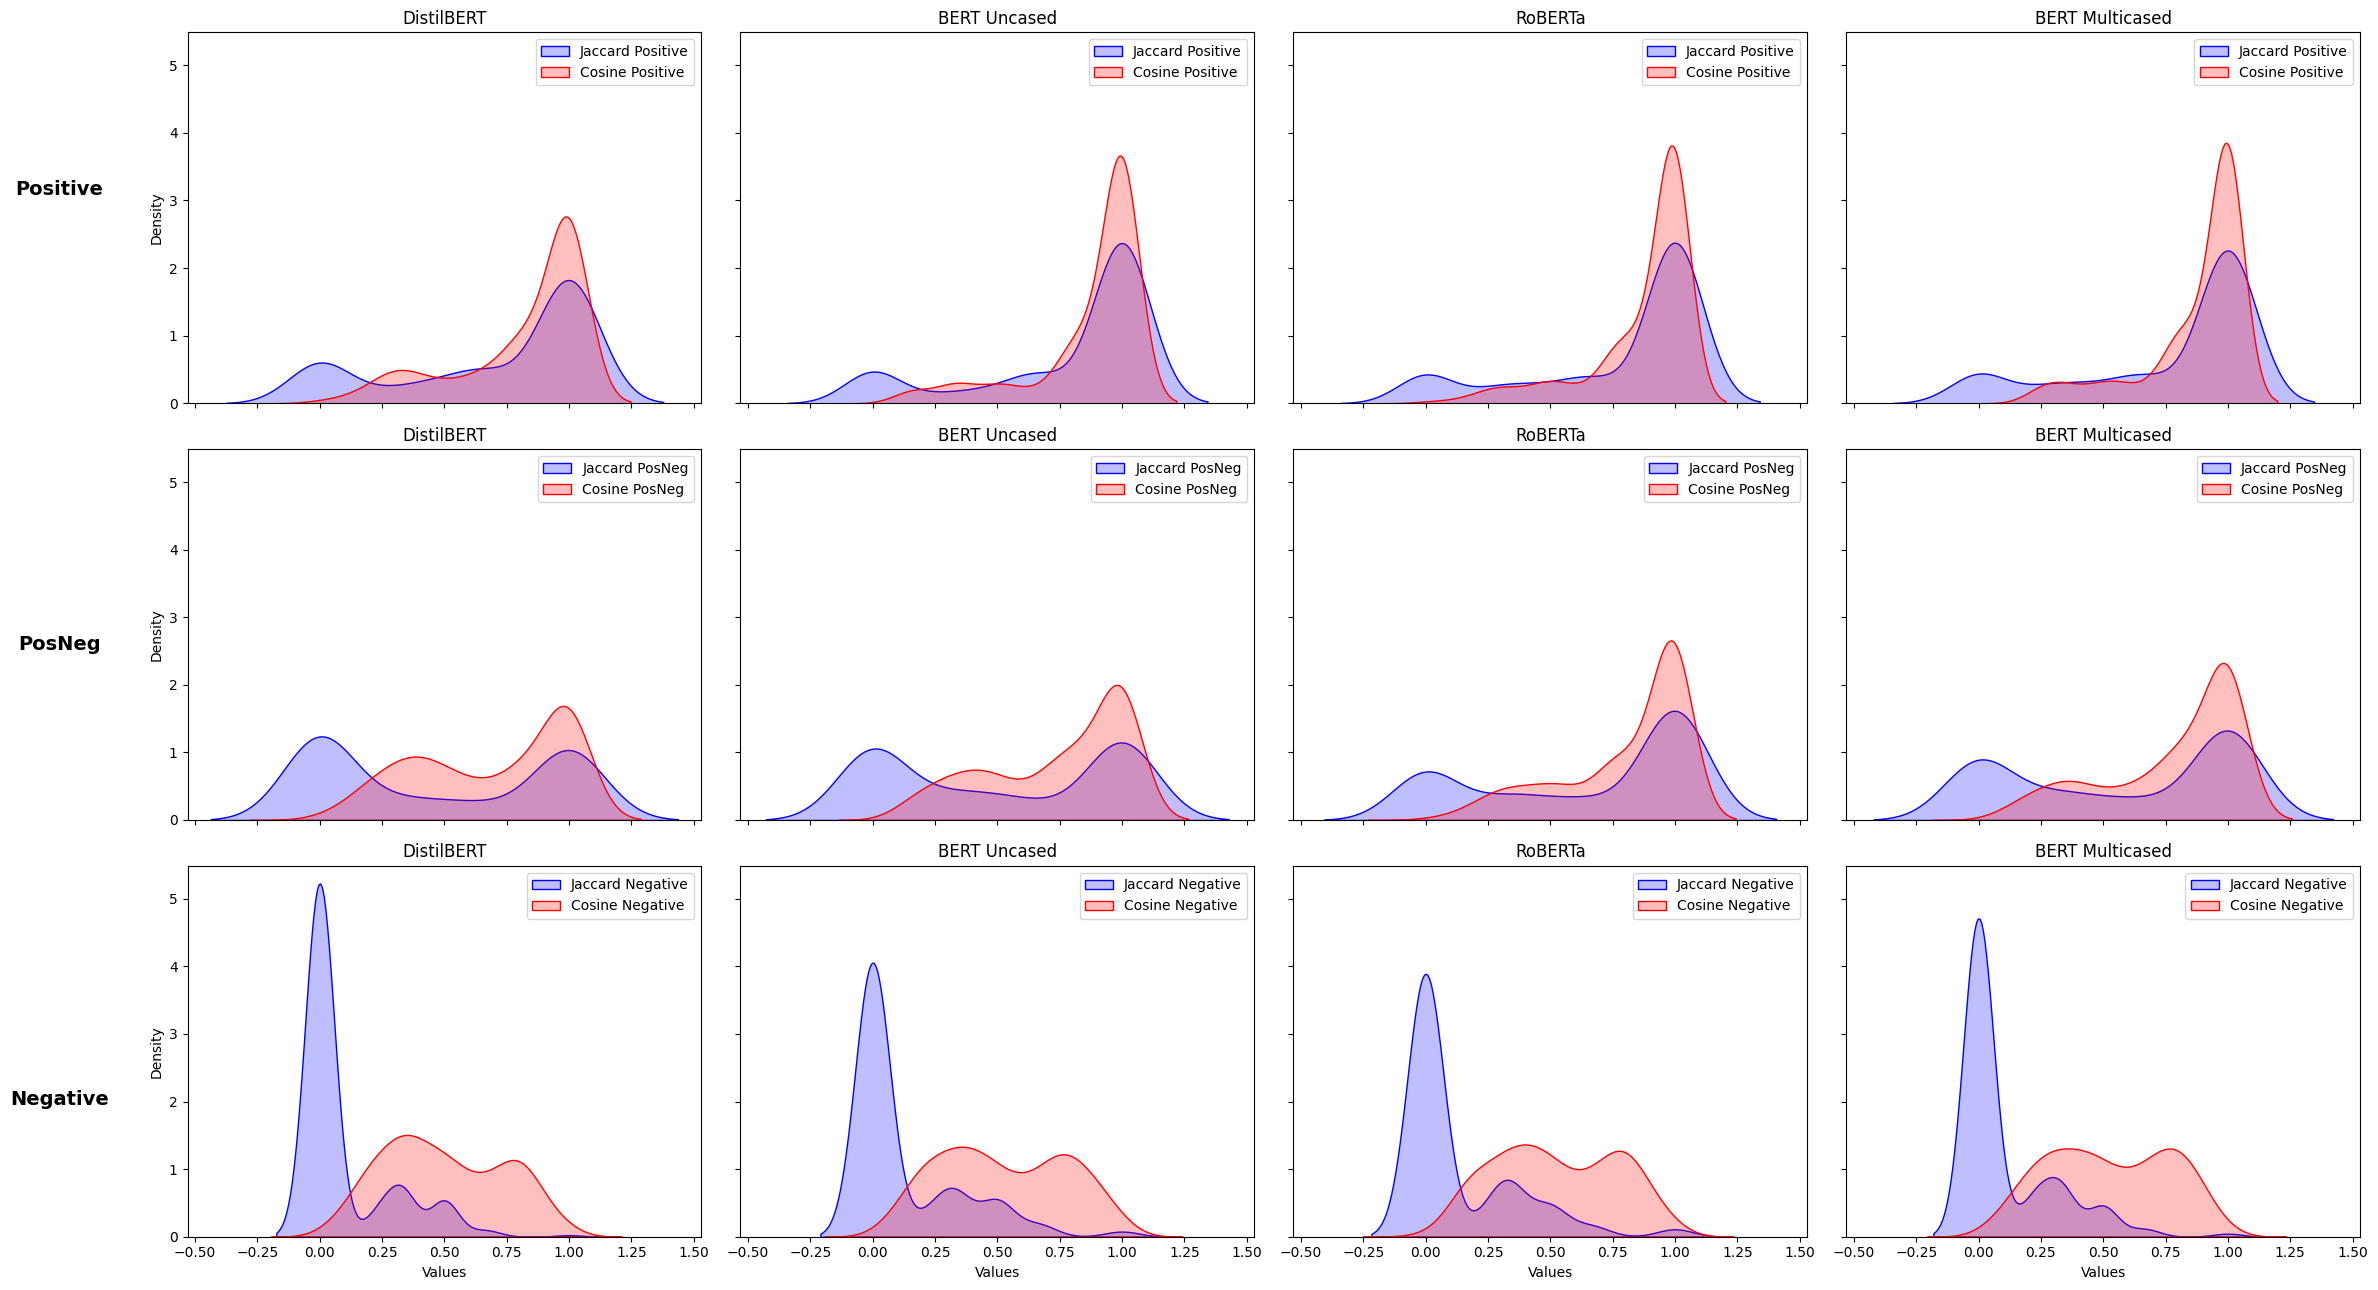

In [34]:
# Definir las columnas a comparar
columns = {
    'Positive': ('Jaccard Positive', 'Cosine Positive'),
    'PosNeg': ('Jaccard PosNeg', 'Cosine PosNeg'),
    'Negative': ('Jaccard Negative', 'Cosine Negative')
}

# Crear los subplots
fig, axes = plt.subplots(3, 4, figsize=(25, 13), sharex=True, sharey=True)

# Iterar sobre los contextos y los dataframes para crear los gráficos de distribución
for (context, (column1, column2)), row_axes in zip(columns.items(), axes):
    for ax, (name, df) in zip(row_axes, dataframes.items()):
        sns.kdeplot(df[column1], ax=ax, label=column1, fill=True, color='blue')
        sns.kdeplot(df[column2], ax=ax, label=column2, fill=True, color='red')
        ax.set_title(f'{name}')
        ax.set_xlabel('Values')
        ax.set_ylabel('Density')
        # ax.set_xlim(0, 1)  # Asegurar que el eje horizontal esté en la escala de 0 a 1
        ax.legend()

# Añadir etiquetas a la izquierda de cada fila
fig.text(0.07, 0.85, 'Positive', va='center', ha='center', rotation=0, fontsize=14, fontweight='bold')
fig.text(0.07, 0.5, 'PosNeg', va='center', ha='center', rotation=0, fontsize=14, fontweight='bold')
fig.text(0.07, 0.15, 'Negative', va='center', ha='center', rotation=0, fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0.1, 0, 1, 1])  # Ajustar el diseño para dar espacio a las etiquetas

# Guardar y mostrar el gráfico
plt.savefig('plots/density_comparison.png', bbox_inches='tight')
plt.show()

# 3. F1 Score Plots

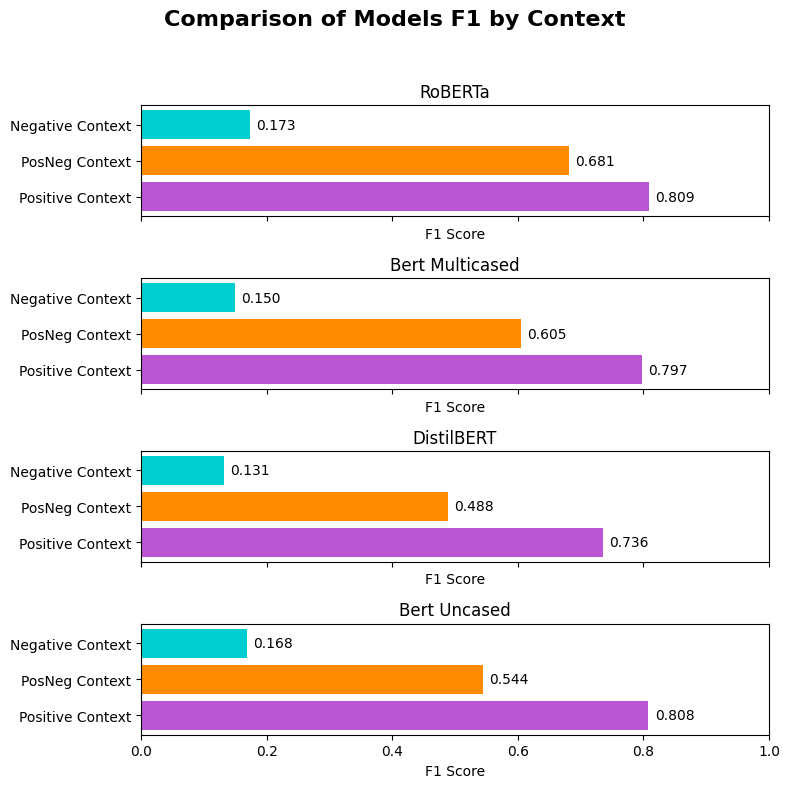

In [47]:
metric_name = 'F1'
file_path = 'metrics/combined_results_json.xlsx'
f1_data = extract_metrics_from_excel(file_path, metric_name)

f1_df = pd.DataFrame(f1_data, index=['Positive Context', 'PosNeg Context', 'Negative Context'])

# Configuración de colores
colors = ['mediumorchid', 'darkorange', 'darkturquoise']

# Crear figura y ejes
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)

# Graficar cada modelo en un subgráfico separado
for ax, (model, data) in zip(axes, f1_df.items()):
    bars = ax.barh(data.index, data, color=colors)
    ax.set_title(model)
    ax.set_xlabel('F1 Score')
    ax.set_xlim(0, 1)  # Ajustar el rango del eje X

    # Agregar las etiquetas de valores en las barras
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.01  # ajustar para que el texto no esté demasiado pegado a la barra
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center')

# Añadir título general a la figura
fig.suptitle('Comparison of Models F1 by Context', fontsize=16, fontweight='bold')

# Ajustar el layout para evitar superposiciones
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Mostrar el gráfico
plt.show()
fig.savefig('plots/F1_comparison.png')

# 4. Exact Matching Plots

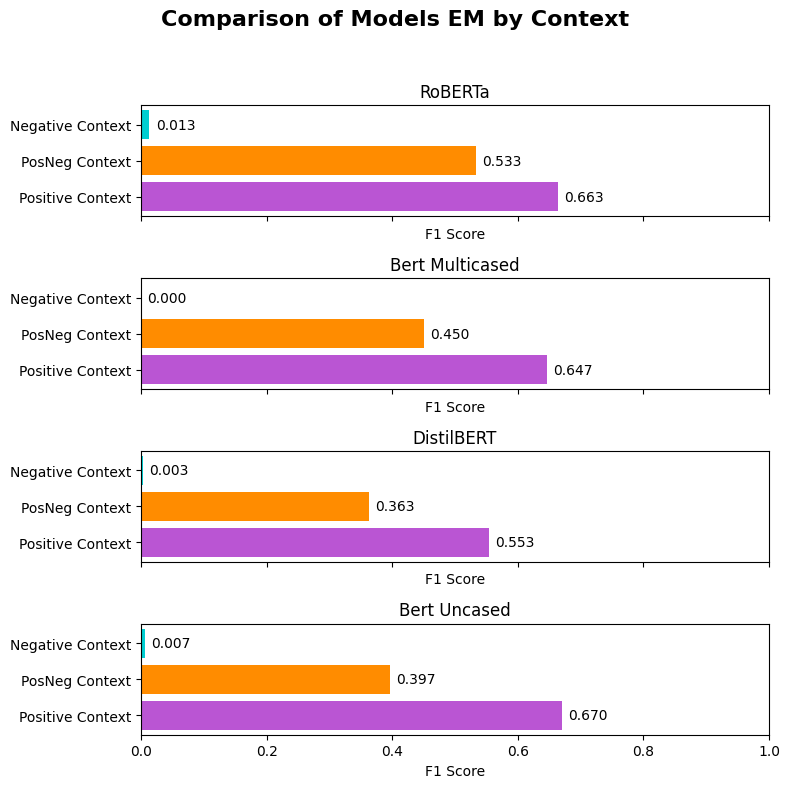

In [49]:
metric_name = 'EM - String'
file_path = 'metrics/combined_results_json.xlsx'
data = extract_metrics_from_excel(file_path, metric_name)

df = pd.DataFrame(data, index=['Positive Context', 'PosNeg Context', 'Negative Context'])

# Configuración de colores
colors = ['mediumorchid', 'darkorange', 'darkturquoise']

# Crear figura y ejes
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)

# Graficar cada modelo en un subgráfico separado
for ax, (model, data) in zip(axes, df.items()):
    bars = ax.barh(data.index, data, color=colors)
    ax.set_title(model)
    ax.set_xlabel('F1 Score')
    ax.set_xlim(0, 1)  # Ajustar el rango del eje X

    # Agregar las etiquetas de valores en las barras
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.01  # ajustar para que el texto no esté demasiado pegado a la barra
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center')

# Añadir título general a la figura
fig.suptitle('Comparison of Models EM by Context', fontsize=16, fontweight='bold')

# Ajustar el layout para evitar superposiciones
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Mostrar el gráfico
plt.show()
fig.savefig('plots/EM_string_comparison.png')

# 5. RougeL Plots

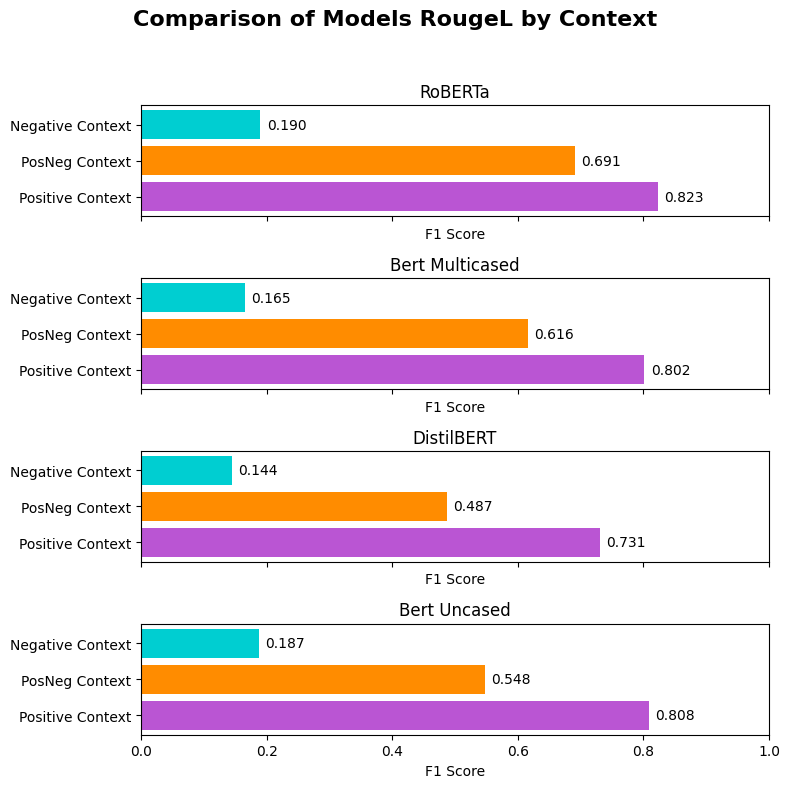

In [50]:
metric_name = 'RougeL'
file_path = 'metrics/combined_results_json.xlsx'
data = extract_metrics_from_excel(file_path, metric_name)

df = pd.DataFrame(data, index=['Positive Context', 'PosNeg Context', 'Negative Context'])

# Configuración de colores
colors = ['mediumorchid', 'darkorange', 'darkturquoise']

# Crear figura y ejes
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)

# Graficar cada modelo en un subgráfico separado
for ax, (model, data) in zip(axes, df.items()):
    bars = ax.barh(data.index, data, color=colors)
    ax.set_title(model)
    ax.set_xlabel('F1 Score')
    ax.set_xlim(0, 1)  # Ajustar el rango del eje X

    # Agregar las etiquetas de valores en las barras
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.01  # ajustar para que el texto no esté demasiado pegado a la barra
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center')

# Añadir título general a la figura
fig.suptitle('Comparison of Models RougeL by Context', fontsize=16, fontweight='bold')

# Ajustar el layout para evitar superposiciones
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Mostrar el gráfico
plt.show()
fig.savefig('plots/rouge_comparison.png')